# Dependencies

In [1]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

### Feature Engineering / Data Cleaning

In [2]:
# Import data
from os.path import dirname, join
from pathlib import Path
# ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root 
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
data_PATH = join(ROOT_DIR[:-16],"data","room_info.csv")  # requires `import os`
print(data_PATH)
# input data
data_raw = pd.read_csv(data_PATH)

c:\Spring 2021\Studio Lab II\arch7211-spring2021\data\room_info.csv


In [5]:
#Cleaning data and feature engineering
exclusion = ["Undefined","UserDefined","Other","Elevated"]
merge = {
    "Sauna": "Bath",
    "Den":"LivingRoom",
    "Alcove":"LivingRoom",
    "Library": "Room",
    "RecreationRoom":"Room",
    "DressingRoom":'Closet',
    "Attic" : "Storage",
    "Office" : "Room",
    "TechnicalRoom":"Utility",
    "DraughtLobby" : "Entry",
    "Hall" : "Entry",
    "Basement" : "Storage"
}

data_raw["type_cleaned"] = data_raw["type"].apply(lambda x: merge.get(x,x))
data_raw["exclude"] = ~data_raw["type"].isin(exclusion)

data_cleaned = data_raw[~data_raw["type"].isin(exclusion)]

In [6]:
data_cleaned.groupby("type_cleaned",as_index=False).count().sort_values("path")

,type_cleaned,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,...,contains_Sink,contains_SpaceForAppliance,contains_Stove,contains_Toilet,contains_TumbleDryer,contains_Urinal,contains_WallCabinet,contains_WashingMachine,contains_WaterTap,exclude
2,CarPort,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
6,Garage,414,414,414,414,414,414,414,414,414,...,414,414,414,414,414,414,414,414,414,414
4,Dining,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
12,Utility,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489
11,Storage,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953
10,Room,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
3,Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
8,LivingRoom,4428,4428,4428,4428,4428,4428,4428,4428,4428,...,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
7,Kitchen,4548,4548,4548,4548,4548,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548
5,Entry,6050,6050,6050,6050,6050,6050,6050,6050,6050,...,6050,6050,6050,6050,6050,6050,6050,6050,6050,6050


In [7]:
# Dividing the raw dataset into three sub categories (tier A,B,C)
# Tiers are: fur = furniture related features, con= space connectivity features, spc = space characteristics features
tier_fur = ['type_cleaned']
tier_spc = []
tier_con = ['type_cleaned']
for col in data_cleaned.columns:
    if 'contains_' in col:
        tier_fur.append(col)
    elif '_to_' in col:
        tier_con.append(col)
    else:
        tier_spc.append(col)
col_select = {
    'tierA' : tier_fur,
    'tierB' : tier_con,
    'tierC' : tier_spc
            } 
#Creating sub-datasets for each tier : tier1) furniture characteristics tier2) fur + connectivity tier 3) whole dataset
data_tier1a = pd.DataFrame(data_cleaned[col_select['tierA']])
data_tier1b = pd.DataFrame(data_cleaned[col_select['tierB']])
data_tier1c = pd.DataFrame(data_cleaned[col_select['tierC']])
data_tier2 = data_tier1c.copy()
data_tier2[col_select['tierB']] = data_tier1b

In [8]:
# # quick view of the dataset grouped by type
# data_tier2.groupby('type_cleaned').count().sort_values('path', ascending= False)

### Functions

In [9]:
# Check redundancy of columns in dataframes
def colUniq (dframe):
    temp = []
    for col in dframe.columns:
        if col not in temp:
            temp.append(col)
    return('num cols in df: ',len(dframe.columns),' num unique cols:',len(temp))
colUniq(data_tier2)

('num cols in df: ', 80, ' num unique cols:', 80)

In [10]:
# Normalizing Confusion Matrix
def matNorm (rawMat):
    test_m = rawMat.copy()
    row_sums = test_m.sum(axis=1)
    new_matrix = test_m / row_sums[:, np.newaxis]
    return new_matrix

## Paths

In [11]:
res_PATH = join(ROOT_DIR[:-16],"CSV")
img_PATH = join(ROOT_DIR[:-16],"Charts_Graphs")
print(res_PATH)
print(img_PATH)

c:\Spring 2021\Studio Lab II\arch7211-spring2021\CSV
c:\Spring 2021\Studio Lab II\arch7211-spring2021\Charts_Graphs


### Model

In [12]:
#Defining Train and Target data
X1 = data_tier1c.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier1c.columns], axis =1)
y1 = data_tier1c['type_cleaned']
#Split the data into training data, and test data 
X_train1 , X_test1, y_train1, y_test1 = train_test_split(X1,y1, test_size= 0.3, stratify=y1)
X_train_train1 , X_train_val1, y_train_train1, y_train_val1 = train_test_split(X_train1,y_train1, test_size= 0.2, stratify=y_train1)

In [15]:
#XGB default parameters
model_1 = XGBClassifier(objective='multi:softprob',
                    learning_rate = 0.02,
                    n_estimators = 1000,
                    max_depth = 6,
                    subsample= 0.9,
                    colsample_bytree = 0.6,
                    n_jobs = -1,
                    seed = 27)
print(model_1)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, seed=27, subsample=0.9,
              tree_method=None, validate_parameters=None, verbosity=None)


## Train Model

In [16]:
model_1.fit(X_train_train1,y_train_train1,
        eval_set=[(X_train_train1, y_train_train1), (X_train_val1, y_train_val1)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

lidation_0-mlogloss:0.42188	validation_0-merror:0.13720	validation_1-mlogloss:0.58967	validation_1-merror:0.18681
[461]	validation_0-mlogloss:0.42148	validation_0-merror:0.13709	validation_1-mlogloss:0.58957	validation_1-merror:0.18681
[462]	validation_0-mlogloss:0.42112	validation_0-merror:0.13702	validation_1-mlogloss:0.58949	validation_1-merror:0.18666
[463]	validation_0-mlogloss:0.42068	validation_0-merror:0.13702	validation_1-mlogloss:0.58939	validation_1-merror:0.18651
[464]	validation_0-mlogloss:0.42030	validation_0-merror:0.13694	validation_1-mlogloss:0.58929	validation_1-merror:0.18666
[465]	validation_0-mlogloss:0.41992	validation_0-merror:0.13669	validation_1-mlogloss:0.58916	validation_1-merror:0.18666
[466]	validation_0-mlogloss:0.41953	validation_0-merror:0.13661	validation_1-mlogloss:0.58907	validation_1-merror:0.18651
[467]	validation_0-mlogloss:0.41920	validation_0-merror:0.13661	validation_1-mlogloss:0.58897	validation_1-merror:0.18637
[468]	validation_0-mlogloss:0.41

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=27, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
evals_result1 = model_1.evals_result()

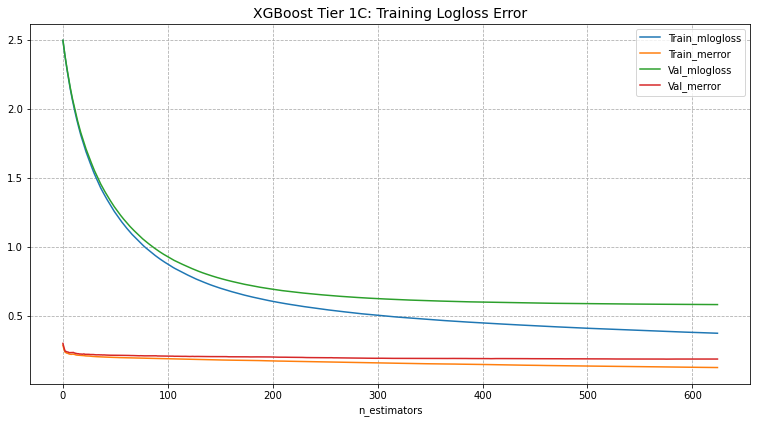

In [24]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_axes([.1,.1,1,1])
file_name = "XGB_Tier1C_mlogloss.png"
fig_PATH = join(img_PATH,file_name)
ax1.plot(evals_result1.get('validation_0').get('mlogloss'), label='Train_mlogloss')   # Train set_mlogloss
ax1.plot(evals_result1.get('validation_0').get('merror'), label='Train_merror')     # Train set_merror
ax1.plot(evals_result1.get('validation_1').get('mlogloss'),label='Val_mlogloss')   #Val set_mlogloss
ax1.plot(evals_result1.get('validation_1').get('merror'),label='Val_merror')     #Val set_merror
ax1.set_title('XGBoost Tier 1C: Training Logloss Error', fontsize = 14)
ax1.legend(loc=1)
ax1.set_xlabel('n_estimators')
plt.grid(True, linestyle="--")

fig1.savefig(fig_PATH)
plt.show()

In [25]:
# Train score : Mean Accuracy
train_score1 = model_1.score(X_train_train1,y_train_train1)
print("Tier 1C Training score: ",train_score1)


Tier 1C Training score:  0.8729063675938906


## Prediction 1

In [26]:
best_iteration1 = model_1.get_booster().best_ntree_limit
y_pred_1 = model_1.predict(X_test1, ntree_limit=best_iteration1)
print("Best Iteration: ",best_iteration1)
# evaluate predictions
accuracy1 = accuracy_score(y_test1, y_pred_1)
print("Accuracy: %.2f%%" % (accuracy1 * 100.0))

Best Iteration:  575
Accuracy: 80.82%


In [27]:
# Report Classification Results
file_name = "XGB_Tier1C_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test1,y_pred_1,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test1,y_pred_1))


              precision    recall  f1-score   support

        Bath       0.80      0.82      0.81      2187
     Bedroom       0.76      0.93      0.84      2398
     CarPort       0.79      0.62      0.69        84
      Closet       0.64      0.64      0.64       912
      Dining       0.77      0.71      0.74       286
       Entry       0.86      0.91      0.88      1815
      Garage       0.71      0.65      0.68       124
     Kitchen       0.88      0.85      0.87      1364
  LivingRoom       0.78      0.87      0.82      1328
     Outdoor       0.95      0.96      0.96      2356
        Room       0.36      0.04      0.08       635
     Storage       0.69      0.65      0.67       586
     Utility       0.62      0.33      0.43       447

    accuracy                           0.81     14522
   macro avg       0.74      0.69      0.70     14522
weighted avg       0.79      0.81      0.79     14522



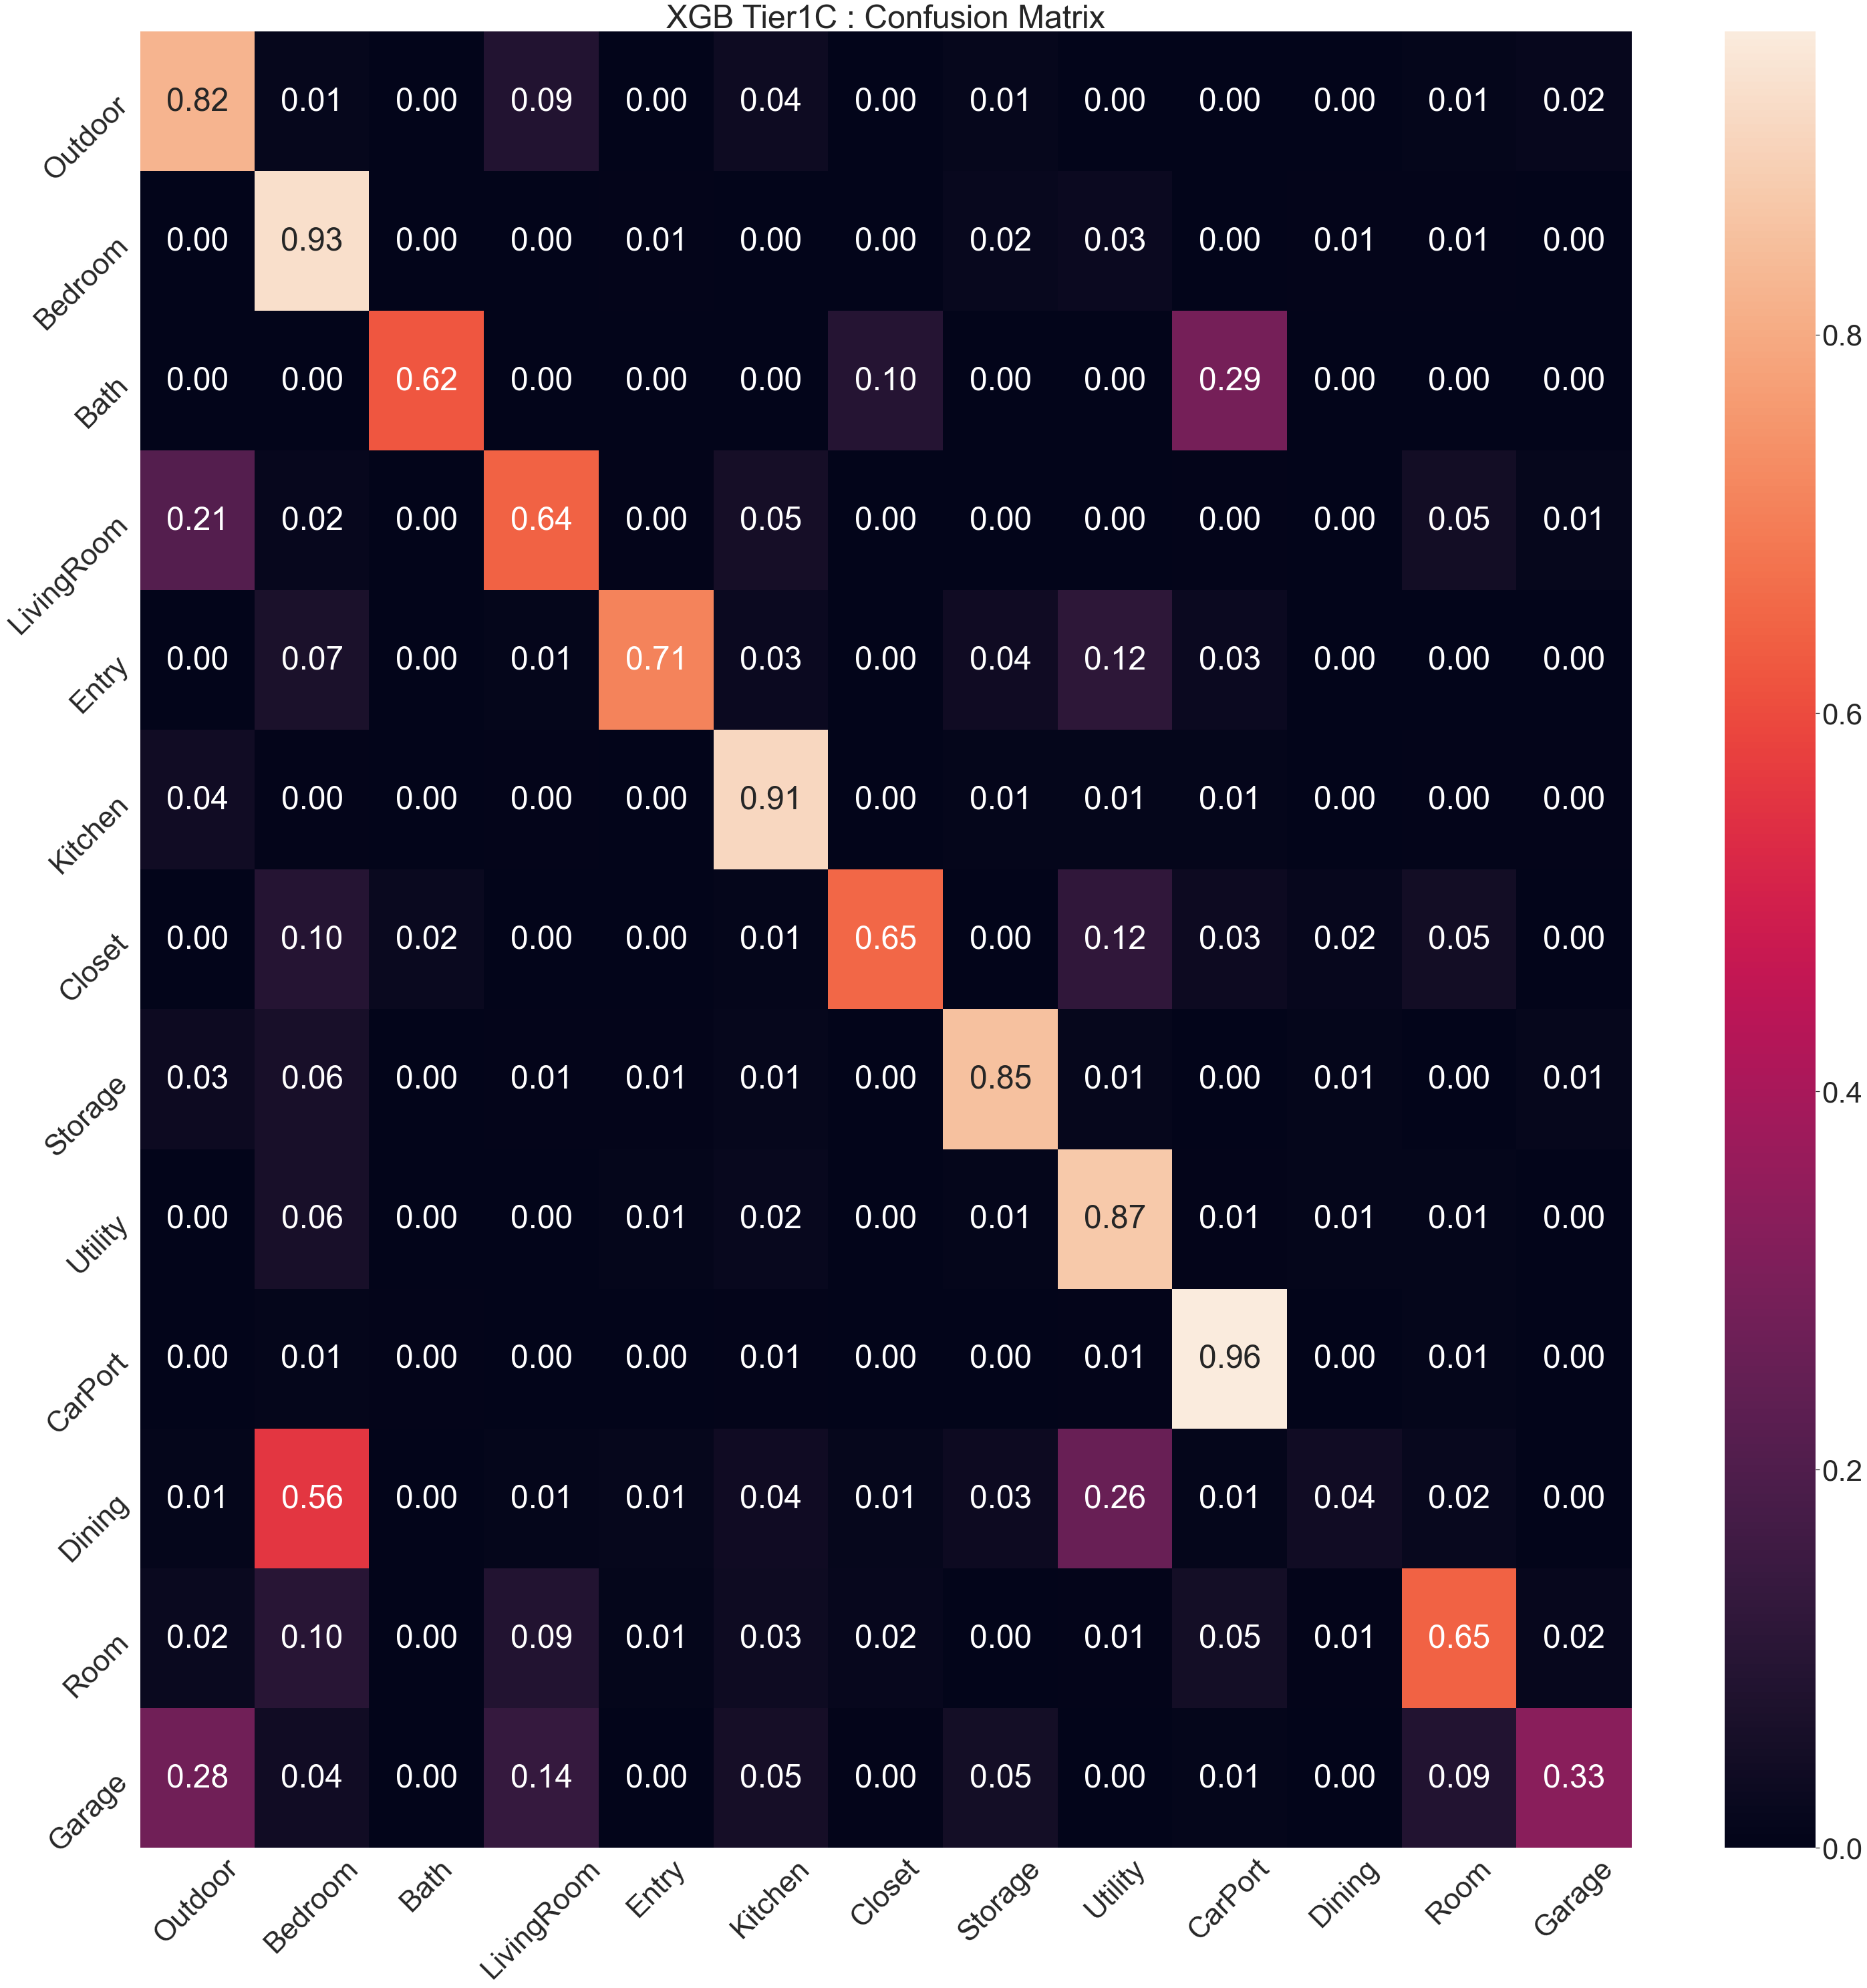

In [29]:
file_name = "XGB_Tier1C_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test1,y_pred_1)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test1).fillna(0).unique() , columns= pd.Series(y_pred_1).fillna(0).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
sns.set(font_scale=4)
plt.title('XGB Tier1C : Confusion Matrix')
plt.savefig(fig_PATH, dpi=300)
plt.show()

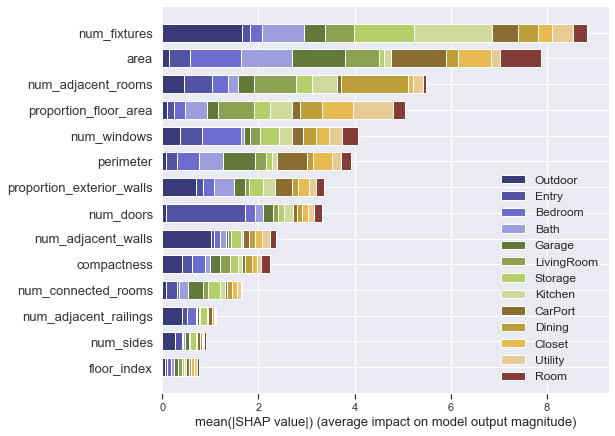

In [31]:
# Feature importance
file_name = "XGB_Tier1C_feat_imp.png"
fig_PATH = join(img_PATH,file_name)
shap_values = shap.TreeExplainer(model_1).shap_values(X_train_train1)
f = plt.figure()
shap.summary_plot(shap_values, X_train_train1,
                  plot_type="bar",class_names=model_1.classes_,
                  title='XGB Tier 1 Feature Importance',
                  color = plt.get_cmap("tab20b"))
f.savefig(fig_PATH, bbox_inches='tight', dpi=300)

In [33]:
#Grid Search based on best sub dataset (between tier1a, 1b, and 1c based on their classification reports)

#Grid Search

#Reproductability
seed = 342
np.random.seed(seed)
#Define CV strategy:
cv = StratifiedKFold(n_splits=5 , shuffle=True, random_state=seed)
#params_grid
params_grid = {
    'max_depth' : [5,6,7,None],
    'subsample': [0.6,0.8,0.9,None],
    'colsample_bytree' : [0.6,0.8,0.9,None]
                }
params_fixed = {
    'objective' : 'multi:softprob',
    'n_estimators' : 575,
    'learning_rate' : 0.02,
    'n_jobs' :-1,
    'verbosity' : 1
                }
bst_grid = GridSearchCV(estimator=XGBClassifier(**params_fixed, seed=seed),param_grid=params_grid, cv = cv, scoring=['f1_macro','accuracy'],return_train_score = True, refit='f1_macro')

In [34]:
fit_params = {
        'eval_set':[(X_train_train1, y_train_train1), (X_train_val1, y_train_val1)],
        'eval_metric':['mlogloss','merror'],
        'early_stopping_rounds':50
                }
bst_grid.fit(X_train_train1,y_train_train1,**fit_params)

lidation_0-mlogloss:0.51795	validation_0-merror:0.15030	validation_1-mlogloss:0.65435	validation_1-merror:0.19079
[194]	validation_0-mlogloss:0.51658	validation_0-merror:0.15015	validation_1-mlogloss:0.65346	validation_1-merror:0.19094
[195]	validation_0-mlogloss:0.51516	validation_0-merror:0.14982	validation_1-mlogloss:0.65252	validation_1-merror:0.19079
[196]	validation_0-mlogloss:0.51379	validation_0-merror:0.14971	validation_1-mlogloss:0.65163	validation_1-merror:0.19094
[197]	validation_0-mlogloss:0.51244	validation_0-merror:0.14971	validation_1-mlogloss:0.65075	validation_1-merror:0.19079
[198]	validation_0-mlogloss:0.51104	validation_0-merror:0.14938	validation_1-mlogloss:0.64987	validation_1-merror:0.19079
[199]	validation_0-mlogloss:0.50982	validation_0-merror:0.14930	validation_1-mlogloss:0.64904	validation_1-merror:0.19079
[200]	validation_0-mlogloss:0.50846	validation_0-merror:0.14919	validation_1-mlogloss:0.64817	validation_1-merror:0.19079
[201]	validation_0-mlogloss:0.50

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missi...
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=342, subsample=None, tree_method=None,
                          

In [35]:
bst_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=575, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [36]:
print('Best params:',bst_grid.best_params_)

Best params: {'colsample_bytree': None, 'max_depth': 7, 'subsample': 0.9}


In [38]:
report_PATH = join(ROOT_DIR[:-16],"CSV","Tier1C_gridsearch.csv")
cv_res_df =pd.DataFrame(bst_grid.cv_results_)
cv_res_df.to_csv(report_PATH)

In [40]:
bst_pred = bst_grid.best_estimator_.predict(X_test1)

In [41]:
report_PATH = join(ROOT_DIR[:-16],"CSV","Tier1C_bestparams_classificationReport.csv")
class_report = classification_report(y_test1,bst_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test1,bst_pred))

              precision    recall  f1-score   support

        Bath       0.79      0.82      0.80      2187
     Bedroom       0.76      0.92      0.83      2398
     CarPort       0.74      0.57      0.64        84
      Closet       0.63      0.64      0.64       912
      Dining       0.75      0.71      0.73       286
       Entry       0.86      0.90      0.88      1815
      Garage       0.73      0.66      0.69       124
     Kitchen       0.88      0.85      0.87      1364
  LivingRoom       0.77      0.87      0.81      1328
     Outdoor       0.95      0.96      0.95      2356
        Room       0.36      0.04      0.07       635
     Storage       0.67      0.65      0.66       586
     Utility       0.63      0.34      0.44       447

    accuracy                           0.80     14522
   macro avg       0.73      0.69      0.69     14522
weighted avg       0.79      0.80      0.79     14522



In [81]:
# TIER 2 -------------------------

#Clean input data from the target data
# define features and predictions
X = data_tier2.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier2.columns], axis =1)
y = data_tier2['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.2)

In [82]:
#XGB default parameters
model = bst_grid.best_estimator_
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=997, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [83]:
model.fit(X_train_train,y_train_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

lidation_0-mlogloss:0.30936	validation_0-merror:0.09444	validation_1-mlogloss:0.47415	validation_1-merror:0.14711
[430]	validation_0-mlogloss:0.30905	validation_0-merror:0.09426	validation_1-mlogloss:0.47405	validation_1-merror:0.14711
[431]	validation_0-mlogloss:0.30872	validation_0-merror:0.09426	validation_1-mlogloss:0.47393	validation_1-merror:0.14726
[432]	validation_0-mlogloss:0.30839	validation_0-merror:0.09411	validation_1-mlogloss:0.47379	validation_1-merror:0.14726
[433]	validation_0-mlogloss:0.30803	validation_0-merror:0.09408	validation_1-mlogloss:0.47366	validation_1-merror:0.14711
[434]	validation_0-mlogloss:0.30762	validation_0-merror:0.09400	validation_1-mlogloss:0.47352	validation_1-merror:0.14771
[435]	validation_0-mlogloss:0.30733	validation_0-merror:0.09393	validation_1-mlogloss:0.47337	validation_1-merror:0.14771
[436]	validation_0-mlogloss:0.30697	validation_0-merror:0.09382	validation_1-mlogloss:0.47326	validation_1-merror:0.14741
[437]	validation_0-mlogloss:0.30

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=997, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
evals_result_tier2 = model.evals_result()

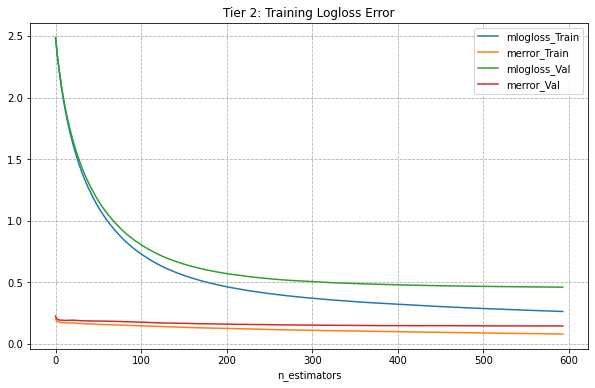

In [85]:

rcParams['figure.figsize'] = 10,6
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier2_mlogloss.png")  # requires `import os`
plt.plot(evals_result_tier2.get('validation_0').get('mlogloss'))   # Train set
plt.plot(evals_result_tier2.get('validation_0').get('merror'))
plt.plot(evals_result_tier2.get('validation_1').get('mlogloss'))   #Val set
plt.plot(evals_result_tier2.get('validation_1').get('merror'))
plt.title('Tier 2: Training Logloss Error')
plt.legend(('mlogloss_Train','merror_Train','mlogloss_Val','merror_Val'),loc=1)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.savefig(fig_PATH)
plt.show()

In [86]:
train_score = model.score(X_train_train,y_train_train)
print("Tier 2 Training score: ",train_score)

Tier 2 Training score:  0.916254703755626


In [87]:
best_iteration = model.get_booster().best_ntree_limit
y_pred = model.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

544


In [88]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.90%


In [89]:
report_PATH = join(ROOT_DIR[:-16],"CSV","Tier2_classificationReport.csv")
class_report = classification_report(y_test,y_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        Bath       0.87      0.92      0.89      2220
     Bedroom       0.80      0.93      0.86      2413
     CarPort       0.77      0.45      0.57        89
      Closet       0.77      0.72      0.75       908
      Dining       0.87      0.87      0.87       270
       Entry       0.91      0.95      0.93      1785
      Garage       0.81      0.79      0.80       140
     Kitchen       0.89      0.89      0.89      1343
  LivingRoom       0.86      0.89      0.87      1368
     Outdoor       0.96      0.97      0.97      2359
        Room       0.45      0.15      0.22       620
     Storage       0.78      0.74      0.76       555
     Utility       0.74      0.57      0.64       452

    accuracy                           0.86     14522
   macro avg       0.81      0.76      0.77     14522
weighted avg       0.85      0.86      0.85     14522



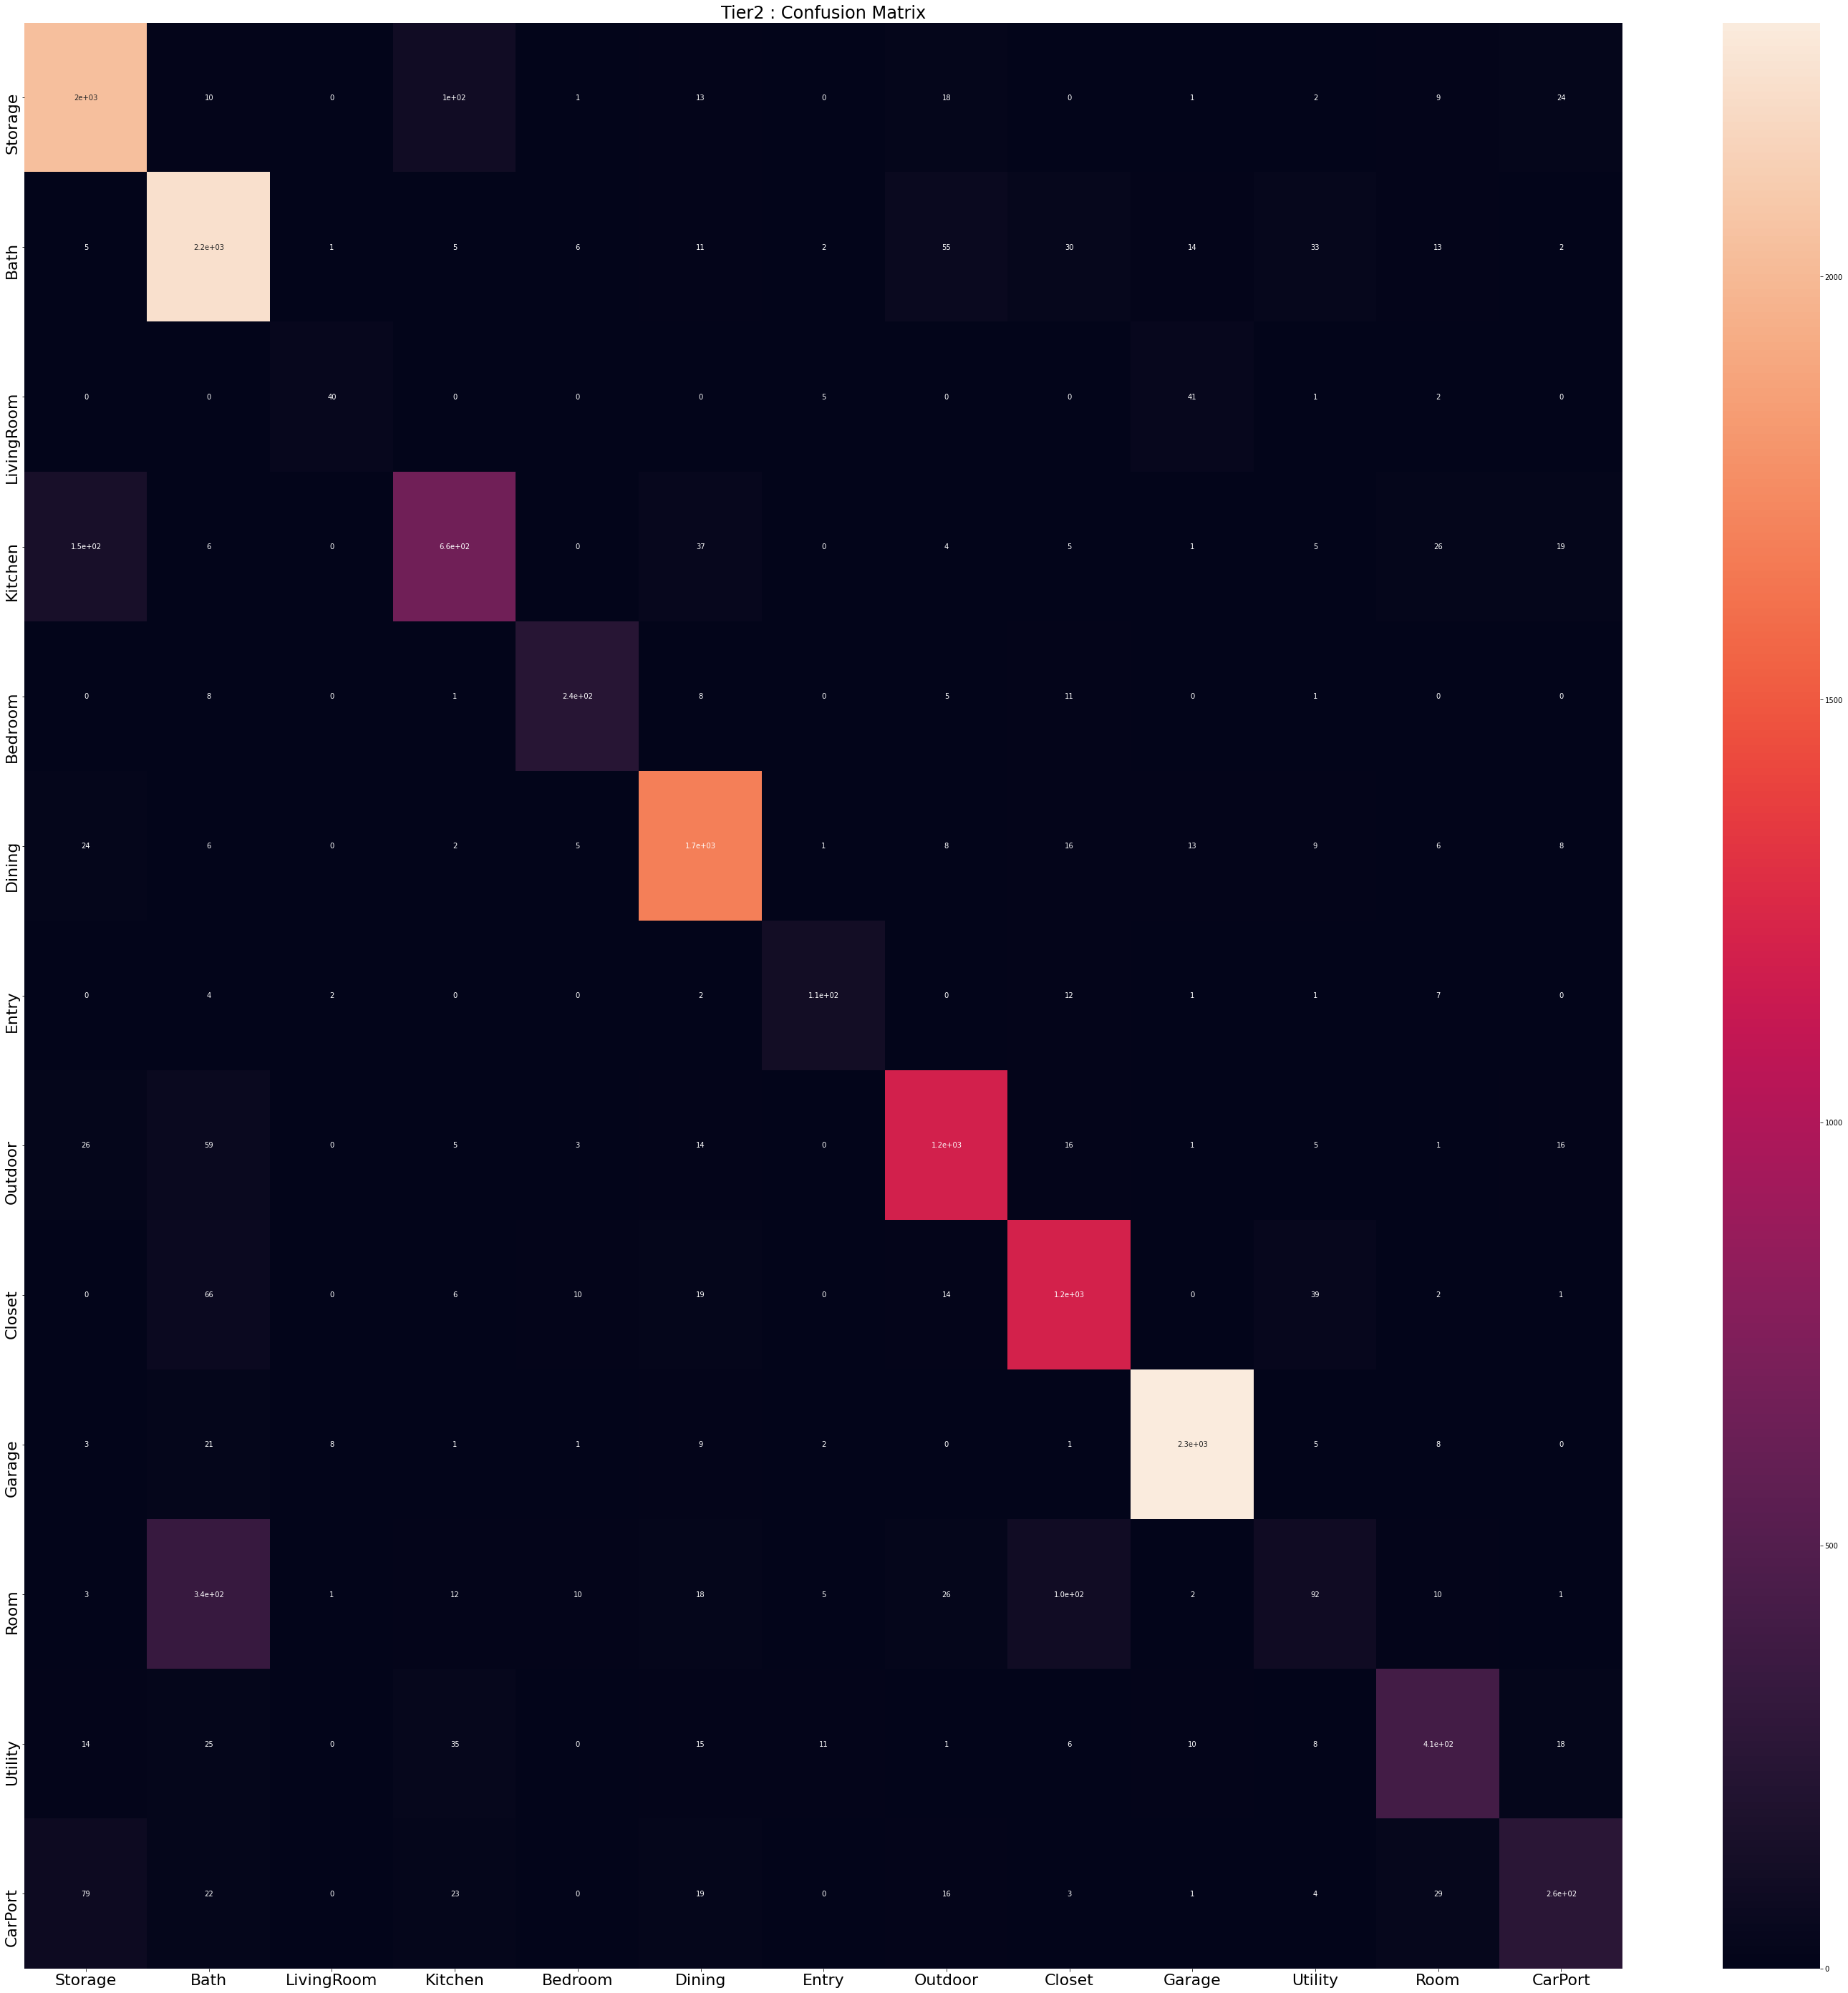

In [91]:
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier2_ConfMat.png")
cMat = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(data = cMat , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred).unique())
# df_cm = pd.DataFrame(data = cMat)
# df_cm.head()
plt.figure(figsize= (50,50))
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
sns.heatmap(df_cm, annot=True)
plt.title('Tier2 : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=100)
plt.show()

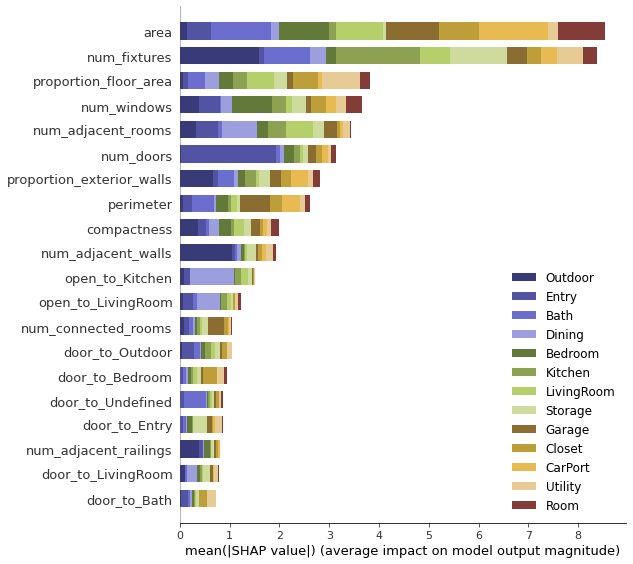

<Figure size 720x432 with 0 Axes>

In [92]:
# Feature importance
shap_values = shap.TreeExplainer(model).shap_values(X_train_train)
shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=model.classes_, title='XGBoost Feature Importance', color = plt.get_cmap("tab20b"))
plt.savefig('Tier 2_featureImp.png',dpi=100)
plt.show()

In [93]:
#Model Final
# TIER 3 -------WHOLE DATA---------

#Clean input data from the target data
# define features and predictions
X = data_cleaned.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_cleaned.columns], axis =1)
y = data_cleaned['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.2)

#model parameters
model_final = bst_grid.best_estimator_
print(model_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=997, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [94]:
model_final.fit(X_train_train,y_train_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

lidation_0-mlogloss:0.24891	validation_0-merror:0.07323	validation_1-mlogloss:0.35777	validation_1-merror:0.10595
[355]	validation_0-mlogloss:0.24849	validation_0-merror:0.07316	validation_1-mlogloss:0.35757	validation_1-merror:0.10580
[356]	validation_0-mlogloss:0.24803	validation_0-merror:0.07301	validation_1-mlogloss:0.35729	validation_1-merror:0.10580
[357]	validation_0-mlogloss:0.24762	validation_0-merror:0.07294	validation_1-mlogloss:0.35711	validation_1-merror:0.10565
[358]	validation_0-mlogloss:0.24722	validation_0-merror:0.07297	validation_1-mlogloss:0.35690	validation_1-merror:0.10565
[359]	validation_0-mlogloss:0.24685	validation_0-merror:0.07290	validation_1-mlogloss:0.35677	validation_1-merror:0.10565
[360]	validation_0-mlogloss:0.24644	validation_0-merror:0.07290	validation_1-mlogloss:0.35660	validation_1-merror:0.10565
[361]	validation_0-mlogloss:0.24603	validation_0-merror:0.07260	validation_1-mlogloss:0.35640	validation_1-merror:0.10550
[362]	validation_0-mlogloss:0.24

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=997, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [109]:
evals_result_final = model_final.evals_result()

In [110]:
train_score_final = model_final.score(X_train_train,y_train_train)
print("Tier 3 Training score: ",train_score)

Tier 3 Training score:  0.916254703755626


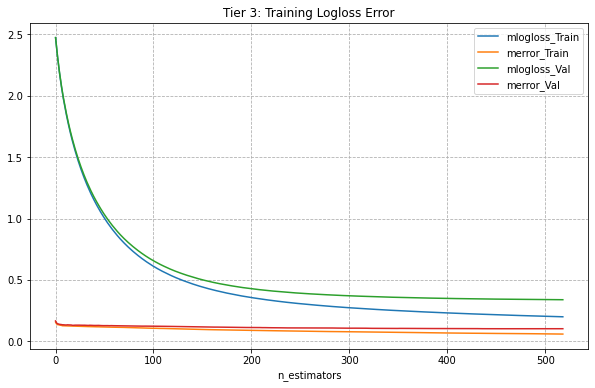

In [112]:
plt.rcParams['font.size'] = 10
rcParams['figure.figsize'] = 10,6
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier3_mlogloss.png")  # requires `import os`
plt.plot(evals_result_final.get('validation_0').get('mlogloss'))   # Train set
plt.plot(evals_result_final.get('validation_0').get('merror'))
plt.plot(evals_result_final.get('validation_1').get('mlogloss'))   #Val set
plt.plot(evals_result_final.get('validation_1').get('merror'))
plt.title('Tier 3: Training Logloss Error')
plt.legend(('mlogloss_Train','merror_Train','mlogloss_Val','merror_Val'),loc=1)
plt.xlabel('n_estimators')
plt.grid(True, linestyle="--")
plt.savefig(fig_PATH)
plt.show()

In [113]:
best_iteration = model_final.get_booster().best_ntree_limit
y_pred_final = model_final.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

469


In [114]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_final)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.38%


In [100]:
report_PATH = join(ROOT_DIR[:-16],"CSV","Tier3_classificationReport.csv")
class_report = classification_report(y_test,y_pred_final,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_final))

              precision    recall  f1-score   support

        Bath       0.97      0.96      0.96      2149
     Bedroom       0.83      0.95      0.89      2415
     CarPort       0.88      0.61      0.72        96
      Closet       0.85      0.89      0.87       878
      Dining       0.92      0.90      0.91       293
       Entry       0.94      0.96      0.95      1843
      Garage       0.71      0.76      0.73       115
     Kitchen       0.97      0.96      0.96      1333
  LivingRoom       0.84      0.91      0.87      1313
     Outdoor       0.96      0.98      0.97      2371
        Room       0.43      0.14      0.21       660
     Storage       0.75      0.75      0.75       579
     Utility       0.88      0.73      0.80       477

    accuracy                           0.89     14522
   macro avg       0.84      0.81      0.82     14522
weighted avg       0.88      0.89      0.88     14522



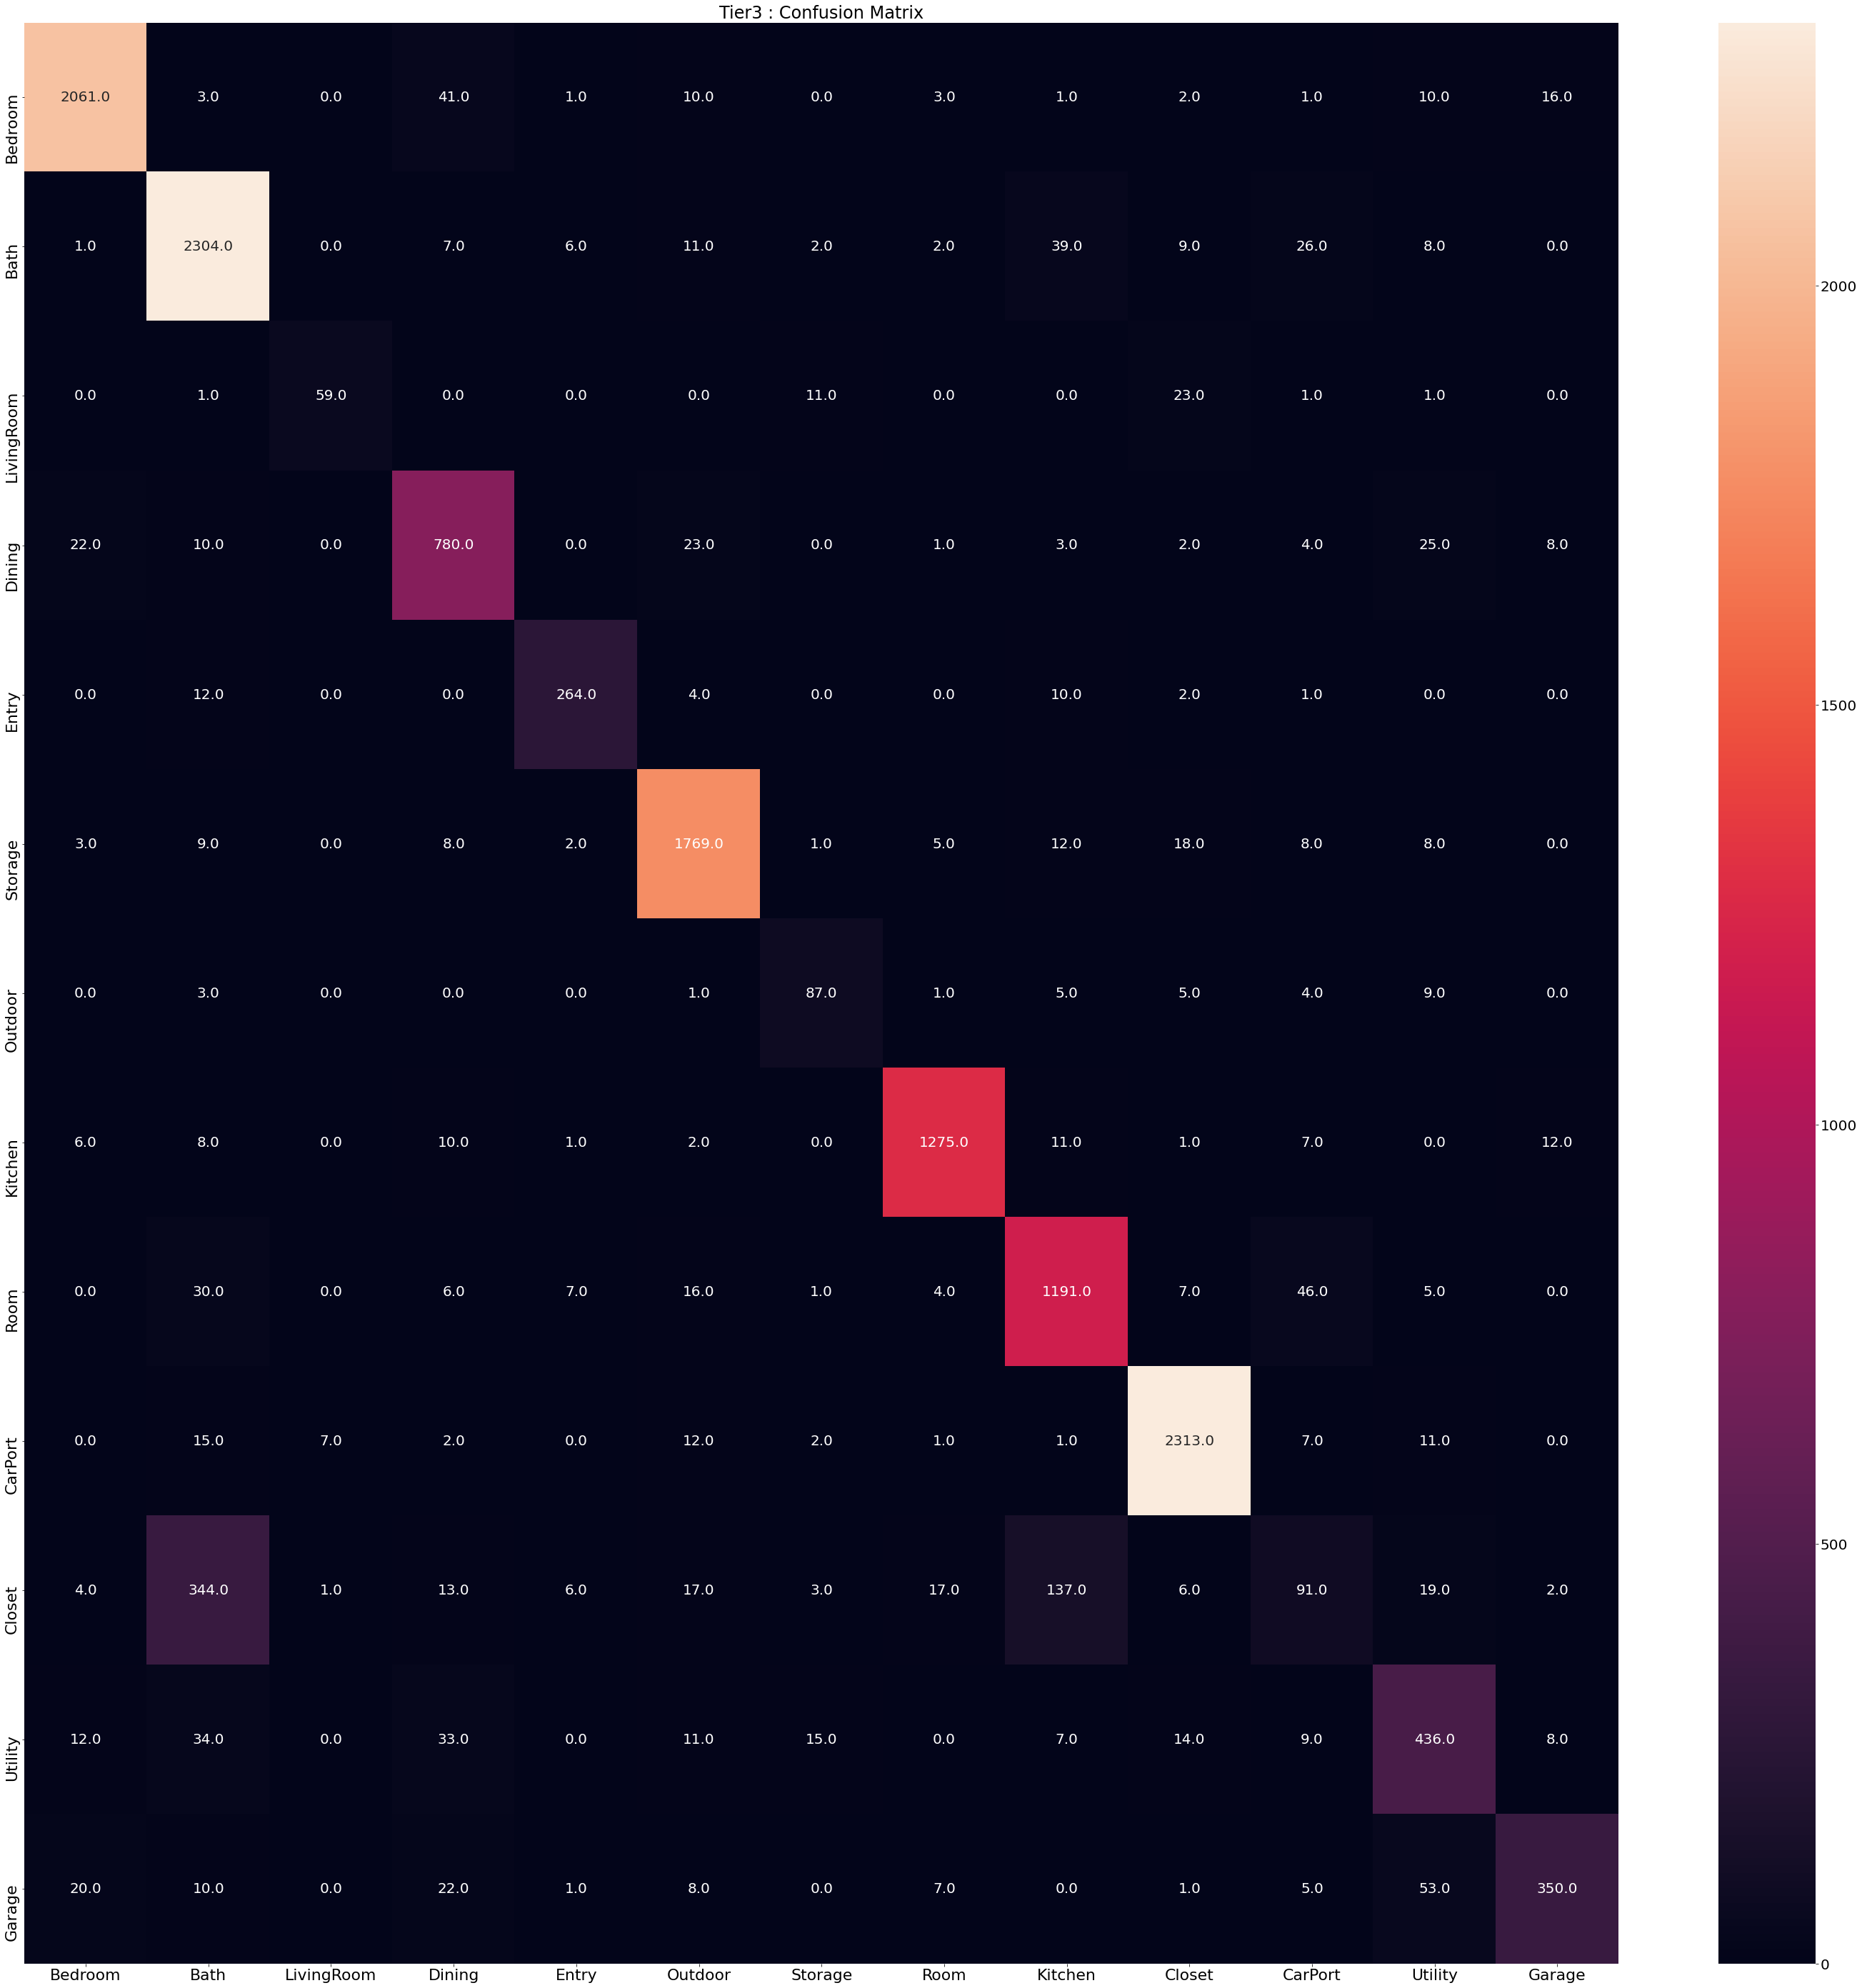

In [106]:
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier3_ConfMat.png")
cMat = confusion_matrix(y_test,y_pred_final)
df_cm = pd.DataFrame(data = cMat , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred_final).unique())
# df_cm = pd.DataFrame(data = cMat)
# df_cm.head()
plt.figure(figsize= (50,50))
plt.rcParams['font.size'] = 20
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
sns.heatmap(df_cm, annot=True, fmt=".1f")
plt.title('Tier3 : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=100)
plt.show()

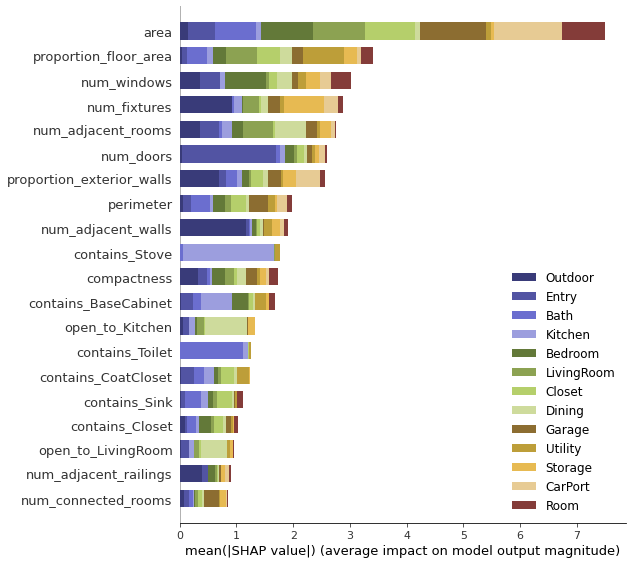

<Figure size 720x432 with 0 Axes>

In [115]:
# Feature importance
shap_values = shap.TreeExplainer(model_final).shap_values(X_train_train)
shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=model_final.classes_, title='XGBoost Feature Importance', color = plt.get_cmap("tab20b"))
plt.show()